In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image
import pandas as pd
from pathlib import Path

In [19]:
from tensorflow.keras.models import load_model

model = load_model("results/model_weights/final_model.h5")

## Configuration

In [2]:
model_path = "../results/model_weights/final_model.h5"  # or .keras
labels_df = pd.read_csv("../data/cibs-ddsm/metadata/labels_resolved.csv")
gradcam_out_dir = Path("../results/gradcam_images")
gradcam_out_dir.mkdir(parents=True, exist_ok=True)

## Loading of model

In [3]:
model = load_model(model_path)
model.summary()  # Identify last Conv2D layer for Grad-CAM

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 224, 224, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_3 (RandomZoom)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,906,947 (91.20 MB)

 Trainable params: 23,906,945 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## Choosing image for preprocessing

In [22]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path).convert("L")  # grayscale
    img = img.resize(target_size)
    img_array = np.array(img).astype("float32") / 255.0
    img_array = np.expand_dims(img_array, axis=(0, -1))  # shape: (1, 224, 224, 1)
    return img_array

## Pick test samples (malignant and benign)

In [23]:
sample_df = labels_df.sample(3)  # or filter: labels_df[labels_df["label"] == 1].sample(3)
print(sample_df[["label", "image_file_path"]])

      label                                    image_file_path
3288      0  ../data/cibs-ddsm/raw/1.3.6.1.4.1.9590.100.1.2...
782       1  ../data/cibs-ddsm/raw/1.3.6.1.4.1.9590.100.1.2...
145       0  ../data/cibs-ddsm/raw/1.3.6.1.4.1.9590.100.1.2...


## Grad-CAM function

In [53]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.input],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)[0]  # (H, W, C)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))      # (C,)

    conv_outputs = conv_outputs[0]                         # (H, W, C)
    # Multiply each channel by corresponding gradient
    heatmap = conv_outputs * pooled_grads                  # element-wise
    heatmap = tf.reduce_sum(heatmap, axis=-1)

    # Normalize
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    if max_val != 0:
        heatmap /= max_val
    return heatmap.numpy()

## Overlay heatmap on image

In [60]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def overlay_heatmap(img_path, heatmap, alpha=0.4, cmap='jet'):
    # Open original image
    img = Image.open(img_path).convert("RGB")  # Ensure RGB
    heatmap = np.uint8(255 * heatmap)          # Scale to 0–255

    # Resize heatmap to match image size
    heatmap = Image.fromarray(heatmap).resize(img.size)
    
    # Apply colormap
    heatmap = np.array(heatmap)
    colormap = plt.get_cmap(cmap)
    heatmap_colored = np.uint8(colormap(heatmap / 255.0) * 255)[:, :, :3]
    heatmap_colored = Image.fromarray(heatmap_colored)

    # Blend heatmap with image
    overlay = Image.blend(img, heatmap_colored, alpha=alpha)
    return overlay

In [61]:
# === RUN Grad-CAM on 5 Sample Malignant Images ===
sample_df = labels_df[labels_df["label"] == 1].sample(5, random_state=42)

In [62]:
print("Shape before model:", img_tensor.shape)  # Should be (1, 224, 224, 1)

Shape before model: (1, 224, 224, 1)


In [63]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom

# Functional API
input_layer = Input(shape=(224, 224, 1))
x = RandomFlip("horizontal")(input_layer)
x = RandomRotation(0.1)(x)
x = RandomZoom(0.1)(x)
x = Conv2D(32, (3, 3), activation="relu")(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation="relu", name="last_conv")(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation="sigmoid")(x)

model = Model(inputs=input_layer, outputs=output_layer)

In [64]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
dummy_input = tf.zeros((1, 224, 224, 1))
_ = model(dummy_input)  # 💡 Now this registers .input and .output

In [65]:
img_array = preprocess_image(sample_df.iloc[0]["image_file_path"])  # (1, 224, 224, 1)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
_ = model(img_tensor)

heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)
overlay = overlay_heatmap(sample_df.iloc[0]["image_file_path"], heatmap)
overlay.show()

/Users/justinlim/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_293']
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)


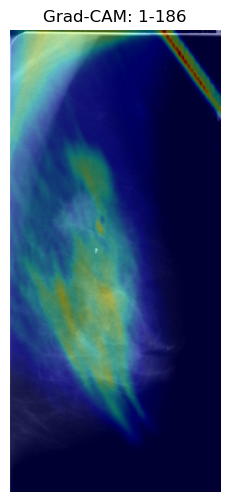

In [66]:
import matplotlib.pyplot as plt

# Display Grad-CAM inline below the cell
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(overlay)
ax.axis('off')
ax.set_title(f"Grad-CAM: {Path(row['image_file_path']).stem}")
plt.show()

/Users/justinlim/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_293']
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)


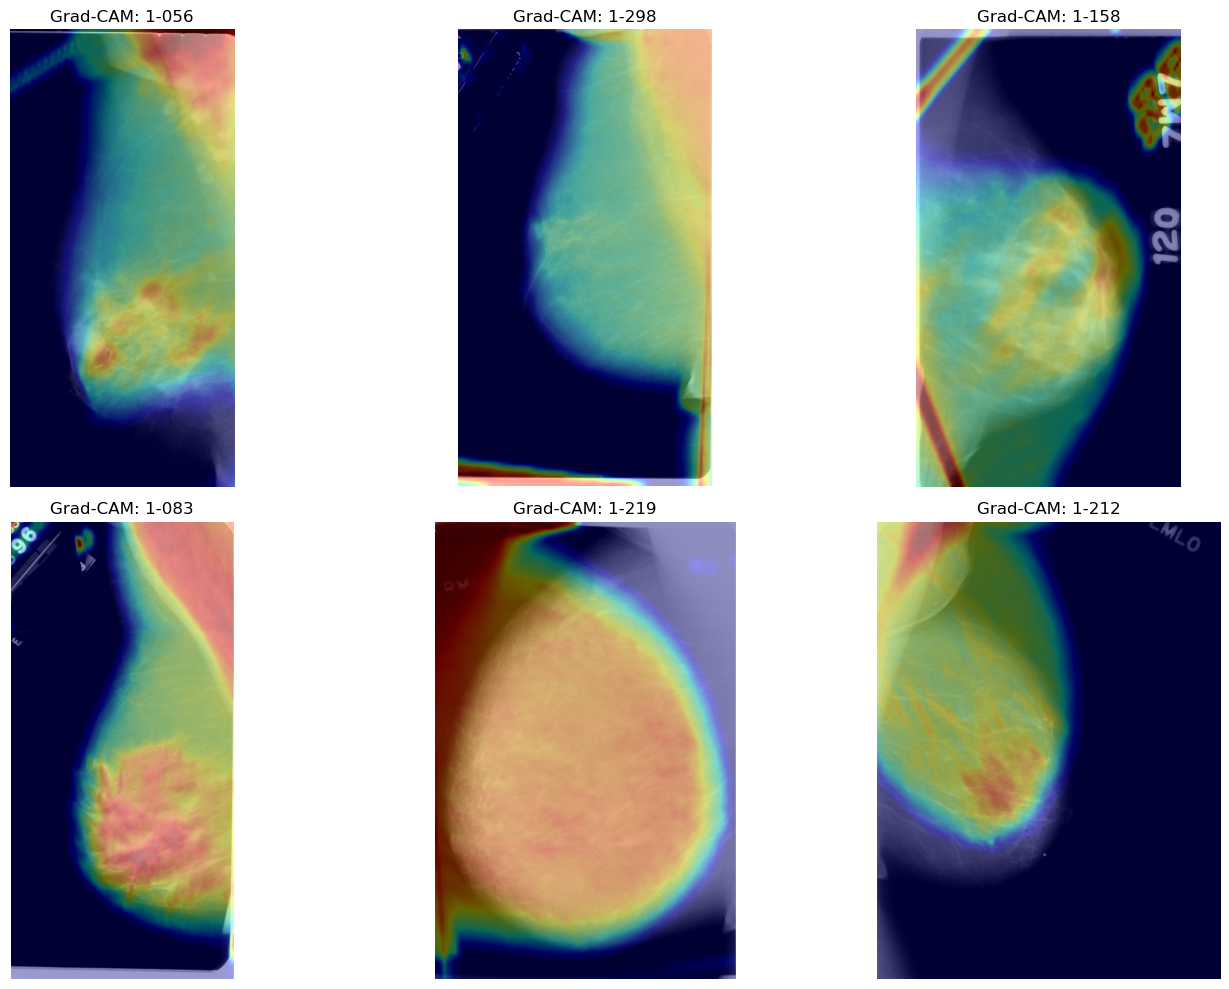

In [69]:
import matplotlib.pyplot as plt

sample_df = labels_df.sample(6, random_state=42)  # or filter by prediction
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, (_, row) in zip(axes.ravel(), sample_df.iterrows()):
    img_array = preprocess_image(row["image_file_path"])  # (1, 224, 224, 1)
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    _ = model(img_tensor)  # build
    heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)
    overlay = overlay_heatmap(row["image_file_path"], heatmap)

    ax.imshow(overlay)
    ax.set_title(f"Grad-CAM: {Path(row['image_file_path']).stem}")
    ax.axis("off")

plt.tight_layout()
plt.show()